In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, ParameterGrid, KFold, \
RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrix
from pyearth import Earth
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import random

In [2]:
data = pd.read_csv('us_used_cars_final.csv')
data.head(2)

,vin,back_legroom,body_type,city,city_fuel_economy,daysonmarket,dealer_zip,description,engine_cylinders,engine_displacement,...,torque,transmission,transmission_display,trimId,trim_name,wheel_system,wheel_system_display,wheelbase,width,year
0,5LMCJ2C97HUL71203,36.8 in,SUV / Crossover,Devine,21.0,40,78016,*We have 19 sources of financing and second ch...,I4,2000.0,...,"270 lb-ft @ 3,000 RPM",A,Automatic,t66989,Select FWD,FWD,Front-Wheel Drive,105.9 in,84.1 in,2017
1,1FM5K8D87HGE07214,39.5 in,SUV / Crossover,Buffalo,16.0,9,55313,We are open for business. Purchase your nex...,V6,3500.0,...,"255 lb-ft @ 4,000 RPM",A,6-Speed Automatic,t67141,XLT AWD,AWD,All-Wheel Drive,112.8 in,90.2 in,2017


## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Distribution of response
*By Hiba Khatib*

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


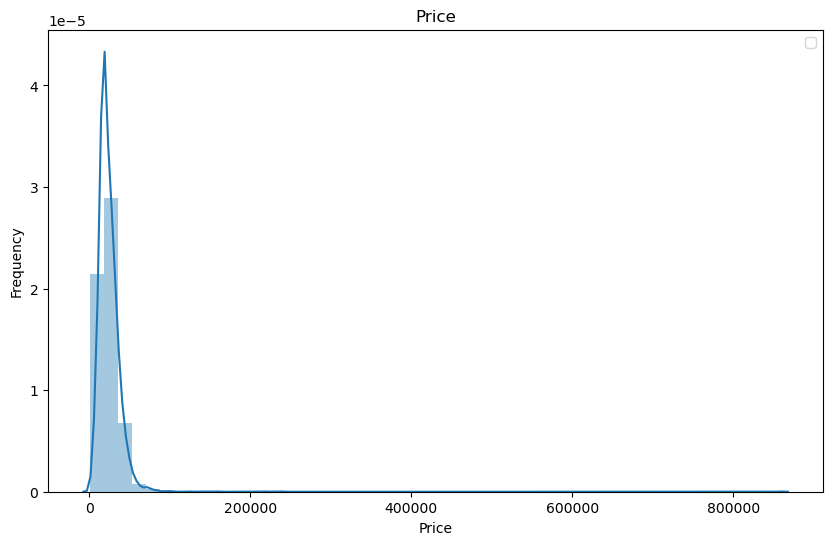

Mean of price:  24568.3835
Standard deviation:  16742.99685916766


In [3]:
#...Plot for distribution of response...#

plt.figure(figsize=(10,6))
sns.distplot(data.price)
plt.title('Price')
plt.legend()
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Mean and standard deviation of response #

print("Mean of price: ", np.mean(data.price))
print("Standard deviation: ", np.std(data.price))

The data needs a log transformation on price. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


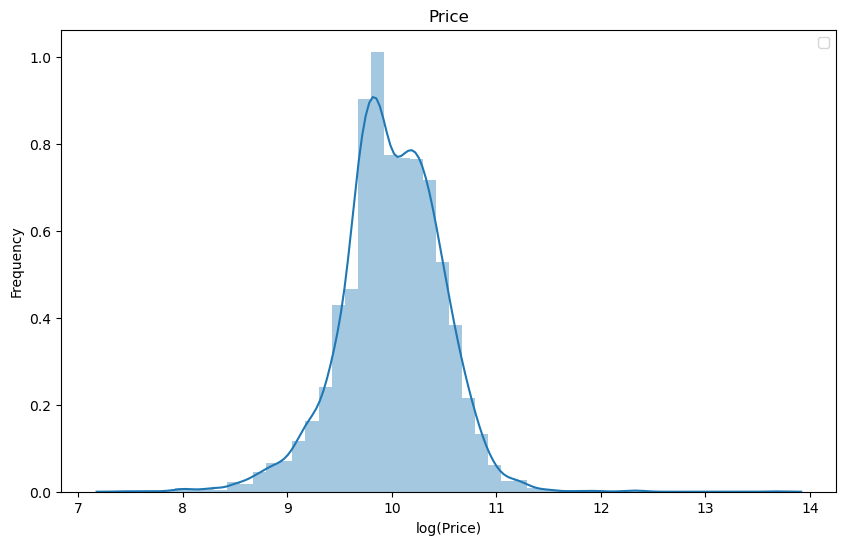

In [4]:
plt.figure(figsize=(10,6))
sns.distplot(np.log(data.price))
plt.title('Price')
plt.legend()
plt.xlabel('log(Price)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

The distribution is much more uniform now with the log transformation. 

<AxesSubplot:xlabel='price'>

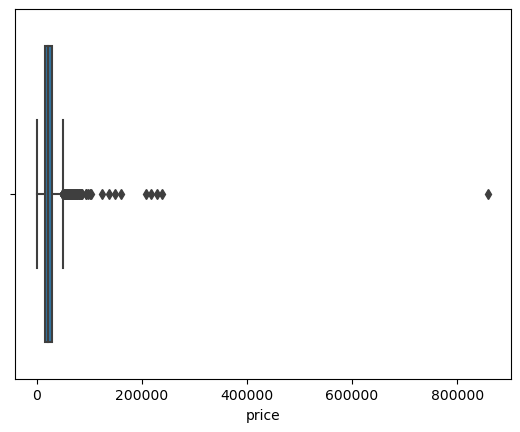

In [5]:
# checking for outlying observations 
sns.boxplot(data.price, orient = "v")

In [6]:
data.price.describe()

count      6000.000000
mean      24568.383500
std       16744.392283
min        1680.000000
25%       16500.000000
50%       21924.000000
75%       29995.000000
max      859000.000000
Name: price, dtype: float64

There appears to be many outliers that we can drop before performing any feature selection. Dropping the outliers should help us avoid possible issues with overfitting to the training data and the complexities that are related to outlying observations. 

In [7]:
data_subset = data[data.price <= 30000]

<AxesSubplot:xlabel='price'>

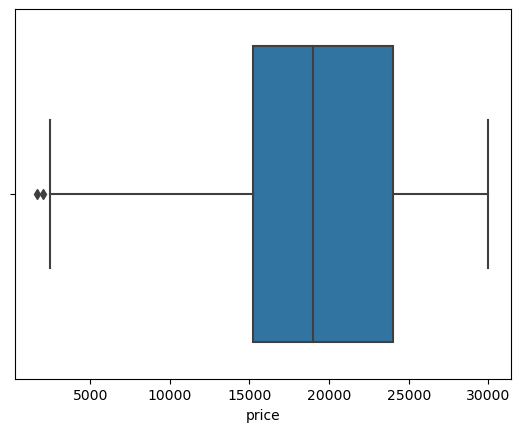

In [8]:
sns.boxplot(data_subset.price)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


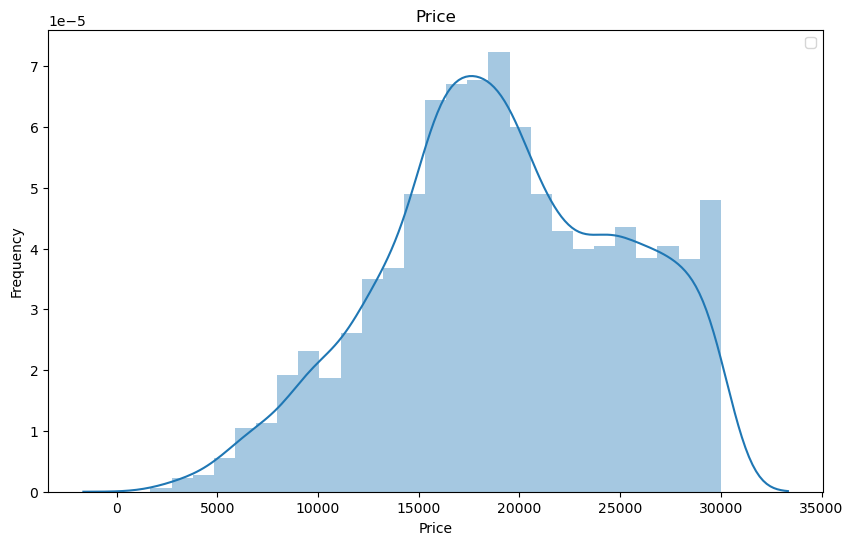

Mean of price:  19205.211827007945
Standard deviation:  5978.306973568847


In [9]:
#...Plot for distribution of response after removing outliers...#

plt.figure(figsize=(10,6))
sns.distplot(data_subset.price)
plt.title('Price')
plt.legend()
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Mean and standard deviation of response #

print("Mean of price: ", np.mean(data_subset.price))
print("Standard deviation: ", np.std(data_subset.price))

The mean and standard deviation have significantly decreased after removing all of the outliers and now we don't need to transform the predictor. The mean and standard deviation have also decreased significantly.

In [10]:
data = data_subset.copy()

In [11]:
print("The final shape of the data after removing outliers is", data.shape)

The final shape of the data after removing outliers is (4532, 57)


### Data Cleaning, Preparation, and EDA
*By Hiba Khatib & Emily Leibfritz*

### brief summary of all the things we did 

After creating all 8 base models, we decided to subset the data into two different ways to improve the analysis of our data. The first subset is the resulting features after our EDA and data preparation. The second way we subsetted the data was based on the features selected by tree based models. Our methods are described in detail below. 

1. Our EDA Selected Features (Hiba & Emily)

We performed data cleaning, preparation and EDA on the data to facilitate feature selection and model training. The first thing we did was fix the data types of some of the columns. All of the boolean columns were encoded as True or False so we mapped those to 1s and 0s. Then, we found that several columns such as horsepower and torque were numerical but contained units. We removed all of the units from these columns and converted them back to numeric. Then, we dropped a set of unique identifiers which were not sigificant to our analysis. We also dropped three columns which represented the interior, and exterior color of the car. These columns had different names for the same color and we did not see them as significant predictors to engineer and encode differently. Then, we dropped a constant predictor which contained the same value for all observations as constant predictors don't provide any meaningful insights. The final step in the cleaning and preparation of the numerical data, we dropped highly correlated features. These were features which represented the same information in two different ways such as the official name of a trim and the id associated with that name. This resulted in us keeping only 14 of the numerical predictors are subsetting for predictors with a correlation of |-.2|. 

# insert summary of categorical data prep 

2. Randomforest and Decision Tree top features (hiba)

In [12]:
# feature engineering

    # encoding True/False as 1/0s
bool_cols = data.dtypes[data.dtypes == bool]
bool_cols = pd.DataFrame(bool_cols).reset_index()
bool_cols = bool_cols['index']
bool_cols = list(bool_cols)
print(bool_cols)
for col in bool_cols:
    data[col] = data[col].map({False: 0, True: 1})
    

    # numerically encoding categorical variables with at most 5 unique values 
cols_map = []
for c in data.columns:
    col_len = (len(data[c].unique()))
    if col_len <=5:
        cols_map.append(c)
[cols_map.remove(c) for c in bool_cols] # removing the boolean columns from the list

    # performing the encoding
le = LabelEncoder()
encoder_dict = {key: None for key in cols_map}
for c in cols_map:
    encoder_dict[c] = data[c].unique()
    col_name = str(c)+"_cat"
    data[col_name] = le.fit_transform(data[c])
    encoder_dict[col_name] = le.fit_transform(encoder_dict[c])
    
    # removing units from numerical columns 

data['front_legroom'] = data['front_legroom'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['width'] = data['width'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['height'] = data['height'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['length'] = data['length'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['wheelbase'] = data['wheelbase'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['back_legroom'] = data['back_legroom'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['maximum_seating'] = data['maximum_seating'].map(lambda x: x.lstrip('+-').rstrip('seating'))
data['fuel_tank_volume'] = data['fuel_tank_volume'].map(lambda x: x.lstrip('+-').rstrip('gal'))
data['power'] = data['power'].str[:3] # keeping only numerical value
data['torque'] = data['torque'].str[:3]

    # converting data types to numerical
data.power = pd.to_numeric(data.power)
data.back_legroom = pd.to_numeric(data.back_legroom)
data.front_legroom = pd.to_numeric(data.front_legroom)
data.width = pd.to_numeric(data.width)
data.height = pd.to_numeric(data.height)
data.length = pd.to_numeric(data.length)
data.wheelbase = pd.to_numeric(data.wheelbase)
data.maximum_seating = pd.to_numeric(data.maximum_seating)
data.fuel_tank_volume = pd.to_numeric(data.fuel_tank_volume)
data.torque = pd.to_numeric(data.torque)

['fleet', 'frame_damaged', 'franchise_dealer', 'has_accidents', 'isCab', 'is_new', 'salvage', 'theft_title']


In [13]:
data.columns

Index(['vin', 'back_legroom', 'body_type', 'city', 'city_fuel_economy',
       'daysonmarket', 'dealer_zip', 'description', 'engine_cylinders',
       'engine_displacement', 'engine_type', 'exterior_color', 'fleet',
       'frame_damaged', 'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'highway_fuel_economy', 'horsepower', 'interior_color', 'isCab',
       'is_new', 'latitude', 'length', 'listed_date', 'listing_color',
       'listing_id', 'longitude', 'main_picture_url', 'major_options',
       'make_name', 'maximum_seating', 'mileage', 'model_name', 'owner_count',
       'power', 'price', 'salvage', 'savings_amount', 'seller_rating', 'sp_id',
       'sp_name', 'theft_title', 'torque', 'transmission',
       'transmission_display', 'trimId', 'trim_name', 'wheel_system',
       'wheel_system_display', 'wheelbase', 'width', 'year', 'fuel_type_cat',
       'transmission_cat', 'wheel_system_cat', 'wheel_syst

In [14]:
# dropping unique features

data.drop(columns = ['vin', 'listing_id', 'main_picture_url', 'description', 'sp_name', 'make_name', 'city'], inplace = True)

    # color columns
data.drop(columns = ['listing_color', 'interior_color', 'exterior_color'], inplace = True)

print("Data shape after dropping unique features: ", data.shape)

# dropping constant predictor 
print(data.nunique() == 1)
data.drop(columns = ['franchise_dealer'], inplace = True)

# dropping highly correlated columns 

data.drop(columns = ['trim_name', 'engine_type', 'major_options', 'horsepower'], inplace = True)

Data shape after dropping unique features:  (4532, 51)
back_legroom                False
body_type                   False
city_fuel_economy           False
daysonmarket                False
dealer_zip                  False
engine_cylinders            False
engine_displacement         False
engine_type                 False
fleet                       False
frame_damaged               False
franchise_dealer             True
franchise_make              False
front_legroom               False
fuel_tank_volume            False
fuel_type                   False
has_accidents               False
height                      False
highway_fuel_economy        False
horsepower                  False
isCab                       False
is_new                      False
latitude                    False
length                      False
listed_date                 False
longitude                   False
major_options               False
maximum_seating             False
mileage                    

In [15]:
print("Final data shape after cleaning and dropping unnecessary features: ", data.shape)

Final data shape after cleaning and dropping unnecessary features:  (4532, 46)


### Exploring Trends in Categorical Predictors

In [16]:
data_2 = data.copy()
# make seperate df to just look at categorical
o_data = data.drop(columns = ["back_legroom", "wheel_system_display", "wheelbase", "width", "front_legroom", 
                              "fuel_tank_volume", "height", "torque", "maximum_seating","transmission_cat",
                              "power","city_fuel_economy","daysonmarket","dealer_zip","transmission","wheel_system_display_cat",
                              "fuel_type_cat","wheel_system","wheel_system_cat","fuel_type",
                              "engine_displacement","fleet","frame_damaged","has_accidents","highway_fuel_economy",
                              "isCab","is_new","latitude","longitude","mileage","owner_count","salvage",
                              "savings_amount","seller_rating","sp_id","theft_title","year"], axis = 1)
# taken out: "franchise_dealer"
cols = o_data.columns
name = []
unique_value = []
for i in range(0,len(cols)):
    c = cols[i]
    unique = len(data[c].unique())
    unique_value.append(unique)
    name.append(c)

In [17]:
# Create the pandas DataFrame with object columns and their unique values
data_ = {'column': name, 'unique_values':unique_value}
o_unique_values_count = pd.DataFrame(data_)
o_unique_values_count.sort_values(by=['unique_values'])

,column,unique_values
0,body_type,9
1,engine_cylinders,16
7,transmission_display,18
2,franchise_make,34
4,listed_date,286
5,model_name,289
3,length,333
8,trimId,2344
6,price,2485


From this information, we can simply visualize with boxplot any variables until make_name, to see their relevance and adjust them. After that we will look more thoroughly, maybe group data. Consider dropping anything with other 1000 unique values as we only have 6000 rows, so might not be good predictors, but will decide on case by case basis.

[]

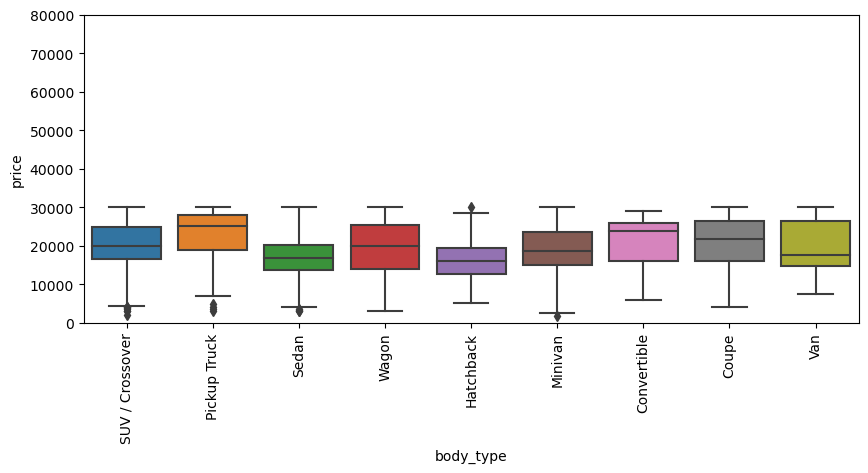

In [18]:
plt.figure(figsize=(10,4))
sns.boxplot(x="body_type",y="price", data = data)
plt.xticks(rotation=90)
plt.ylim(0,80000)

plt.plot()

body_type seems to have a significant trend right away. We cancheck value counts to see if some types are more common than others

In [19]:
data.body_type.value_counts()

SUV / Crossover    2295
Sedan              1503
Pickup Truck        190
Minivan             184
Wagon               115
Hatchback           108
Coupe                98
Convertible          27
Van                  12
Name: body_type, dtype: int64

Have enough observations for each value to be valid, none of the smaller groups stand out substantially, convertible is a little bit spread but that should be fine -> convert to dummies

In [20]:
# change spelling so colummns will be callable
data_2['body_type'] = o_data['body_type'].apply(lambda x: 'SUV_Crossover' if x == 'SUV / Crossover' else 
                                                          'Pickup_Truck' if x == 'Pickup Truck' else
                                                x)
# get dummies
data_2 = pd.get_dummies(data_2, columns=['body_type'], drop_first=True)

[]

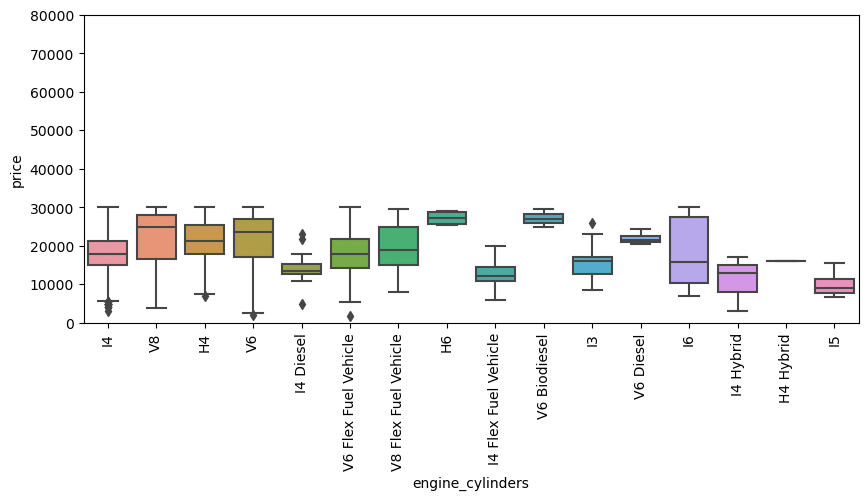

In [21]:
plt.figure(figsize=(10,4))

sns.boxplot(x="engine_cylinders",y="price", data = o_data)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

In [22]:
o_data.engine_cylinders.value_counts()

I4                      2776
V6                      1223
V6 Flex Fuel Vehicle     156
H4                       145
V8                       105
V8 Flex Fuel Vehicle      45
I4 Flex Fuel Vehicle      22
I4 Diesel                 16
I3                        13
I6                        12
H6                         4
V6 Diesel                  4
I5                         4
V6 Biodiesel               3
I4 Hybrid                  3
H4 Hybrid                  1
Name: engine_cylinders, dtype: int64

Turn anything under 100 observations into 'other', if there is only one observation this is not useful data.

In [23]:
data_2['engine_cylinders'] = o_data['engine_cylinders'].apply(lambda x: 'I4' if x == 'I4' else 
                                                          'V6' if x == 'V6' else
                                                          'V8' if x == 'V8' else
                                                          'V6_Flex_Fuel_Vehicle' if x == 'V6 Flex Fuel Vehicle' else
                                                          'H4' if x == 'H4' else
                                                          'other')
data_2.engine_cylinders.value_counts()

I4                      2776
V6                      1223
V6_Flex_Fuel_Vehicle     156
H4                       145
other                    127
V8                       105
Name: engine_cylinders, dtype: int64

[]

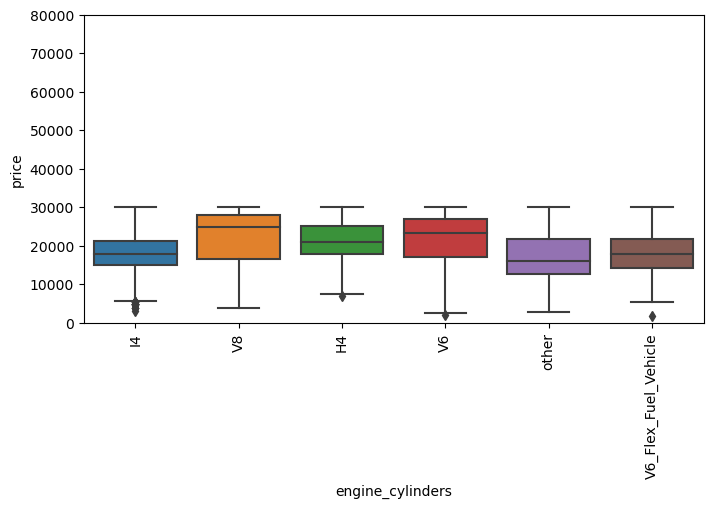

In [24]:
plt.figure(figsize=(8,4))
sns.boxplot(x="engine_cylinders",y="price", data = data_2)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

Other is naturally with bigger range, but this looks better, get dummies for it:

In [25]:
data_2 = pd.get_dummies(data_2, columns=['engine_cylinders'], drop_first=True)

[]

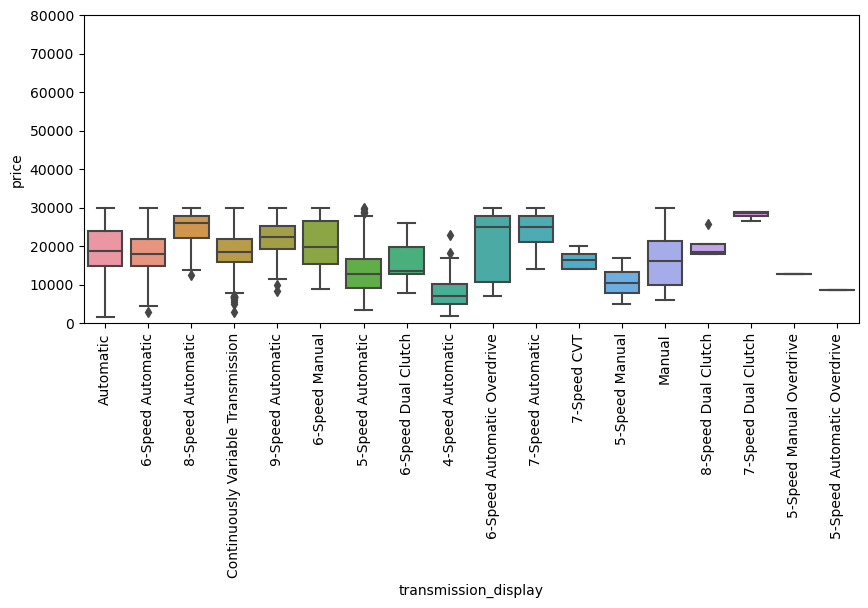

In [26]:
plt.figure(figsize=(10,4))
sns.boxplot(x="transmission_display",y="price", data = o_data)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

Mean and range seem both to be varying, might be valuable column to predict price, check value counts:

In [27]:
data.transmission_display.value_counts().head()

Automatic                             1583
6-Speed Automatic                     1157
Continuously Variable Transmission     934
8-Speed Automatic                      334
9-Speed Automatic                      189
Name: transmission_display, dtype: int64

[]

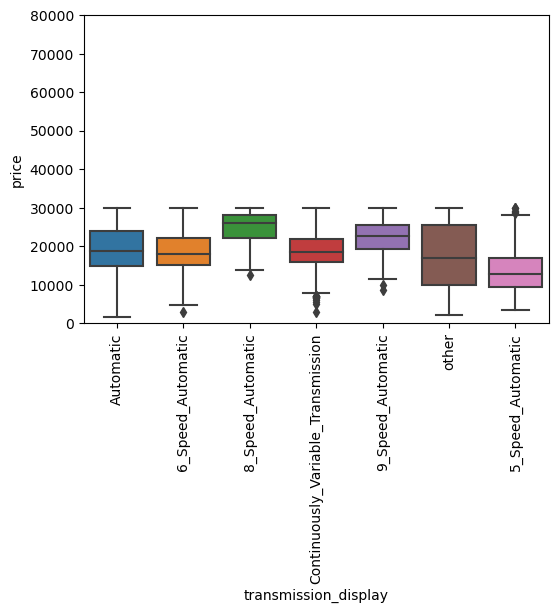

In [28]:
data_2['transmission_display'] = o_data['transmission_display'].apply(lambda x: 'Automatic' if x == 'Automatic' else 
                                                          '6_Speed_Automatic' if x == '6-Speed Automatic' else
                                                          'Continuously_Variable_Transmission' if x == 'Continuously Variable Transmission' else
                                                          '8_Speed_Automatic' if x == '8-Speed Automatic' else
                                                          '9_Speed_Automatic' if x == '9-Speed Automatic' else
                                                          '6_Speed_Automatic' if x == '6-Speed Automatic' else
                                                          '5_Speed_Automatic' if x == '5-Speed Automatic' else
                                                          'other')
plt.figure(figsize=(6,4))
sns.boxplot(x="transmission_display",y="price", data = data_2)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

Looks relevant, change in mean and besides 2 relatively small range -> convert into dummies

In [29]:
# turn those columns into dummies
data_2 = pd.get_dummies(data_2, columns=['transmission_display'], drop_first=True)

[]

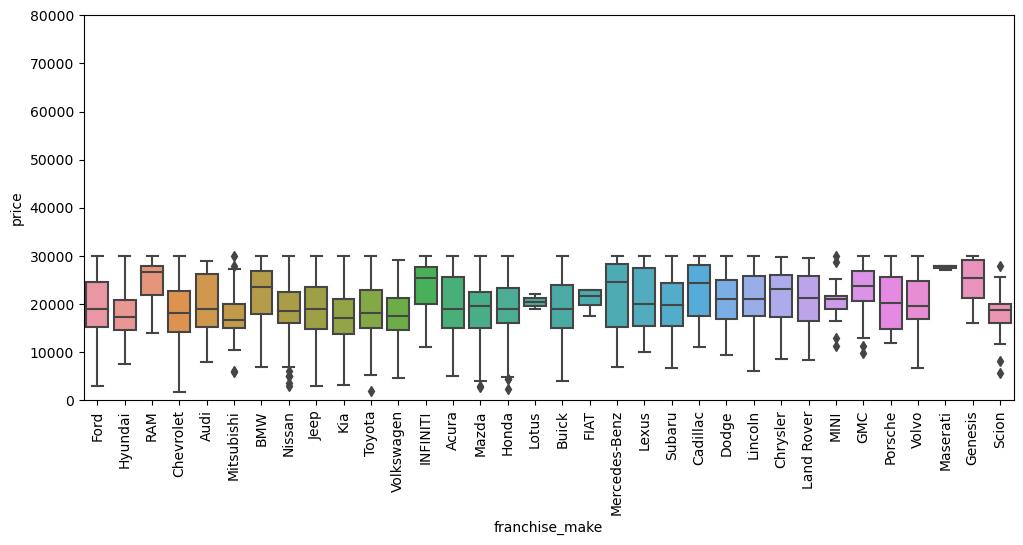

In [30]:
plt.figure(figsize=(12,5))
sns.boxplot(x="franchise_make",y="price", data = o_data)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

This seems to be too many columns to just turn into dummies, and as brand is strongly connected to price this seems an important column to keep -> divide brands into groups depending on their mean price, and label encode these groups.

In [31]:
# look at mean price by group
brand_mean_price=data.groupby('franchise_make', as_index=False)['price'].mean()
brand_mean_price=brand_mean_price.sort_values(by=['price'])
brand_mean_price.head()

,franchise_make,price
16,Kia,17610.859551
25,Mitsubishi,17617.980000
29,Scion,17778.894737
32,Volkswagen,18031.586957
13,Hyundai,18046.270270


In [32]:
# sort the brands into groups with similar means
group_0 = brand_mean_price.iloc[0:8,0]
group_1 = brand_mean_price.iloc[8:14,0]
group_2 = brand_mean_price.iloc[14:19,0]
group_3 = brand_mean_price.iloc[19:25,0]
group_4 = brand_mean_price.iloc[25:34,0]
group_5 = brand_mean_price.iloc[34:38,0]
group_6 = brand_mean_price.iloc[38:40,0]

# write function to get names
def get_names (group):
    final = []
    for i in range(0,len(group)):
        name = group.iloc[i]
        final.append(name)
    return(final)
# list of names in each group
names_0 = get_names(group_0)
names_1 = get_names(group_1)
names_2 = get_names(group_2)
names_3 = get_names(group_3)
names_4 = get_names(group_4)
names_5 = get_names(group_5)
names_6 = get_names(group_6)

# replace each object with a number of their group
data_2['franchise_make'] = o_data['franchise_make'].apply(lambda x: 0 if x in names_0 else
                                                          1 if x in names_1 else
                                                          2 if x in names_2 else
                                                          3 if x in names_3 else
                                                          4 if x in names_4 else
                                                          5 if x in names_5 else
                                                          6 if x in names_6 else
                                                         'wrong')

In [33]:
data.listed_date.value_counts().head()

2020-09-02    163
2020-08-28    119
2020-09-03    110
2020-08-27    109
2020-08-30    105
Name: listed_date, dtype: int64

In [34]:
#simply turn into numerical
import datetime
data_2['listed_date']=pd.to_datetime(data_2["listed_date"]).dt.strftime("%Y%m%d")
data_2['listed_date']=data_2.listed_date.astype(int)
# get correlation
data_2['listed_date'].corr(data_2['price'])

-0.027944370408355405

Has a negative correlation between listing date and price, rather small

In [35]:
data.model_name.value_counts().head()

Escape     166
Rogue      146
Accord     125
Corolla    114
RAV4       108
Name: model_name, dtype: int64

Looking at both head and tail, there is a good distribution of the different model names, not one that is prelevant wherease the rest only has 1 or 2 entries -> group and turn into numeric

In [36]:
# look at grouped mean
make_mean_price=data.groupby('model_name', as_index=False)['price'].mean()
make_mean_price=make_mean_price.sort_values(by=['price'])
make_mean_price.head()

,model_name,price
195,QX4,2000.0
164,Mariner Hybrid,2953.0
95,Explorer Sport Trac,2995.0
101,Five Hundred,3000.0
182,Park Avenue,3000.0


In [37]:
# like with other column, divide 361 rows into 7 groups, different sizes but around same mean
group_0 = make_mean_price.iloc[0:100,0] # 2000-15000
group_1 = make_mean_price.iloc[100:194,0] # 15000-25000 
group_2 = make_mean_price.iloc[194:237,0] # 25000-30000 
group_3 = make_mean_price.iloc[237:279,0] # 30000-35000
group_4 = make_mean_price.iloc[279:329,0] # 35000-50000
group_5 = make_mean_price.iloc[319:352,0] # 50000-10000
group_6 = make_mean_price.iloc[352:362,0] # rest

# list of names in each group
names_0 = get_names(group_0)
names_1 = get_names(group_1)
names_2 = get_names(group_2)
names_3 = get_names(group_3)
names_4 = get_names(group_4)
names_5 = get_names(group_5)
names_6 = get_names(group_6)

# replace each object with a number of their group
data_2['model_name'] = o_data['model_name'].apply(lambda x: 0 if x in names_0 else
                                                          1 if x in names_1 else
                                                          2 if x in names_2 else
                                                          3 if x in names_3 else
                                                          4 if x in names_4 else
                                                          5 if x in names_5 else
                                                          6 if x in names_6 else
                                                         'wrong')

In [38]:
# drop first letter of each row
data_2['trimId'] = data['trimId'].str.slice(1)
# convert to integer
data_2['trimId']=data_2.trimId.astype(int)
# look at correlation
data_2['trimId'].corr(data_2['price'])

0.5706133697377519

In [39]:
# drop categorical version of columns we have numerical copy of
data_2 = data_2.drop(columns=["transmission","wheel_system_display","fuel_type","wheel_system"], axis = 1)

In [40]:
dat_types = pd.DataFrame(data_2.dtypes)

In [41]:
dat_types.value_counts()

int64      21
uint8      19
float64    18
dtype: int64

In [42]:
data_2.shape

(4532, 58)

In [43]:
data = data_2

In [44]:
data

,back_legroom,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_make,front_legroom,fuel_tank_volume,...,engine_cylinders_V6,engine_cylinders_V6_Flex_Fuel_Vehicle,engine_cylinders_V8,engine_cylinders_other,transmission_display_6_Speed_Automatic,transmission_display_8_Speed_Automatic,transmission_display_9_Speed_Automatic,transmission_display_Automatic,transmission_display_Continuously_Variable_Transmission,transmission_display_other
0,36.8,21.0,40,78016,2000.0,0,0,1,42.8,15.5,...,0,0,0,0,0,0,0,1,0,0
2,36.8,23.0,30,37129,2500.0,0,0,1,43.1,15.4,...,0,0,0,0,0,0,0,1,0,0
5,38.2,21.0,161,73069,2000.0,0,0,0,41.5,16.4,...,0,0,0,0,1,0,0,0,0,0
6,40.3,15.0,14,48836,5700.0,0,0,4,41.0,26.0,...,0,0,1,0,0,1,0,0,0,0
7,40.9,21.0,49,12701,2400.0,1,0,0,44.1,18.8,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5994,33.4,23.0,1,95407,2000.0,0,0,1,43.1,12.4,...,0,0,0,0,0,0,0,0,0,1
5995,37.0,20.0,88,15146,2000.0,0,0,3,44.3,18.0,...,0,0,0,0,1,0,0,0,0,0
5996,39.8,22.0,38,77065,2500.0,0,0,0,45.8,18.5,...,0,0,0,0,0,0,0,1,0,0
5997,37.3,22.0,92,84341,2000.0,0,0,1,43.1,15.7,...,0,0,0,0,0,0,0,1,0,0


### Feature Selection 

In [45]:
final_corrs = pd.DataFrame(data.corrwith(data.price)).reset_index().sort_values(by = 0, ascending = False)

final_corr_cols = list(final_corrs.loc[(final_corrs[0] >= 0.2) | (final_corrs[0] <= -0.2)][1:]['index'])
final_corrs.loc[(final_corrs[0] >= 0.2) | (final_corrs[0] <= -0.2)][1:]

,index,0
21,model_name,0.581373
34,year,0.574644
31,trimId,0.570613
23,power,0.406592
30,torque,0.386623
33,width,0.303995
53,transmission_display_8_Speed_Automatic,0.268433
32,wheelbase,0.256636
11,height,0.245438
48,engine_cylinders_V6,0.245117


In [46]:
X = data.copy()

for col in X:
    if col not in final_corr_cols:
        X.drop(col, axis = 1, inplace = True)

X.shape

(4532, 23)

We have 23 predictors which have a reasonable correlation with price which we will be the only predictors we use in our model building. 

When we develop our models, we will print the feature importances and note which features are deemed significant by each model. 

In [47]:
# checking for any new NAs 
X.isna().sum()

city_fuel_economy                         0
engine_displacement                       0
franchise_make                            0
fuel_tank_volume                          1
height                                    1
highway_fuel_economy                      0
length                                    1
mileage                                   0
model_name                                0
owner_count                               0
power                                     0
savings_amount                            0
torque                                    0
trimId                                    0
wheelbase                                 1
width                                     1
year                                      0
wheel_system_cat                          0
wheel_system_display_cat                  0
body_type_Sedan                           0
engine_cylinders_I4                       0
engine_cylinders_V6                       0
transmission_display_8_Speed_Aut

In [48]:
y = data.price 
y.isna().sum()

0

The original dataset had '--' for this one observation. When we performed the data cleaning and prep, these observations were not considered missing but became missing after our feature engineering. We can drop this observation since it is only one row with data missing from the original source. 

In [49]:
X.isna().sum()
X.iloc[29]
X.drop(29, inplace = True)
y.drop(29, inplace = True)

In [50]:
X.to_csv('X.csv')
y.to_csv('y.csv')

In [51]:
clean_X = X.copy()
clean_y = y.copy()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)

### Features Selection using Tree Based Models

Using the tree based methods such as RandomForest and DecisionTrees will allow us to double check if our feature selection has been significant or if it produces better results for base models.

The original shape of our data after removing the outliers is 4532, 58.

After our data cleaning and dropping of the units, we created some NaN values which can be dropped. We can confidently drop these observations because they were initially missing but encoded as '--' which is why we did not initially discover that they were missing. These are 31 observations which we can drop which brings our data shape to 4301, 58

In [53]:
data.shape

(4532, 58)

In [54]:
data_copy = data.copy()
data_copy.dropna(inplace = True)
data_copy.shape

(4501, 58)

In [55]:
X_tree = data_copy.drop(columns = ['price'])
y_tree = data_copy.price

#### Base Random Forest Feature Selection

In [56]:
rf_features = RandomForestRegressor(random_state = 4).fit(X_tree, y_tree)
rf_feats = pd.DataFrame(zip(rf_features.feature_names_in_, rf_features.feature_importances_))

In [57]:
rf_feats.sort_values(by = 1, ascending = False)

,0,1
30,trimId,3.681064e-01
21,model_name,2.059636e-01
23,power,1.224561e-01
20,mileage,8.733049e-02
29,torque,2.501834e-02
0,back_legroom,1.947877e-02
25,savings_amount,1.366988e-02
11,height,1.346977e-02
47,engine_cylinders_V6,9.795723e-03
33,year,9.452366e-03


In [58]:
rf_feats[(rf_feats[1] >= 0.2) | (rf_feats[1] <= -.2)]

,0,1
21,model_name,0.205964
30,trimId,0.368106


In [59]:
base_dt = DecisionTreeRegressor(random_state = 4).fit(X_tree, y_tree)
dt_feats = pd.DataFrame(zip(base_dt.feature_names_in_, base_dt.feature_importances_))
dt_feats.sort_values(by = 1, ascending = False)
dt_feats[(dt_feats[1] >= 0.2) | (dt_feats[1] <= -.2)]

,0,1
21,model_name,0.211757
30,trimId,0.379266


In [60]:
bagged_dt = BaggingRegressor(DecisionTreeRegressor(), random_state = 4, n_estimators = 100).fit(X_tree, y_tree)
f_imp = pd.DataFrame(zip(bagged_dt.feature_names_in_,np.mean([tree.feature_importances_ for tree in bagged_dt.estimators_], axis = 0)))

In [61]:
f_imp.sort_values(by = 1, ascending = False)
f_imp[(f_imp[1] >= 0.2) | (f_imp[1] <= -.2)]

,0,1
21,model_name,0.205927
30,trimId,0.368145


Based on the base Random Forest, the two most significant predictors are model_name and trimId. We can test the performance of a model developed using our feature selection and a model developed using the selected features by the RandomForest to find the best predictors. 

In [62]:
X_tree_subset = X_tree[['model_name', 'trimId']]

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_tree_subset, y_tree, test_size = 0.3, random_state = 4)

Base MARS model on the tree selected features: 

In [63]:
base_mars1 = Earth().fit(X_train_sub, y_train_sub)
print(base_mars1.summary())
print("Base MARS train RMSE", np.sqrt(base_mars1.mse_))
print("\nBase MARS train R^2", base_mars1.rsq_)
print("\nBASE MARS Test RMSE", mean_squared_error(y_test_sub, base_mars1.predict(X_test_sub), squared = False))
print("\nBASE MARS Test R^2", r2_score(y_test_sub, base_mars1.predict(X_test_sub)))

Earth Model
--------------------------------------
Basis Function   Pruned  Coefficient  
--------------------------------------
(Intercept)      No      14093.4      
h(trimId-67312)  Yes     None         
h(67312-trimId)  No      -0.228409    
model_name       No      3970.31      
h(trimId-32660)  No      0.196858     
h(32660-trimId)  Yes     None         
h(trimId-83763)  Yes     None         
h(83763-trimId)  Yes     None         
h(trimId-89881)  No      -1.31739     
h(89881-trimId)  No      -0.932045    
h(trimId-78253)  No      -6.47566     
h(78253-trimId)  Yes     None         
h(trimId-76583)  No      2.17212      
h(76583-trimId)  Yes     None         
h(trimId-78985)  No      3.86031      
h(78985-trimId)  Yes     None         
h(trimId-82290)  Yes     None         
h(82290-trimId)  No      1.05506      
--------------------------------------
MSE: 12520924.7798, GCV: 12709856.5249, RSQ: 0.6517, GRSQ: 0.6466
Base MARS train RMSE 3538.491879292508

Base MARS train R^2 0.65

Base MARS model on our selected features: 

In [64]:
base_mars2 = Earth().fit(X_train, y_train)
print(base_mars2.summary())
print("Base MARS train RMSE", np.sqrt(base_mars2.mse_))
print("\nBase MARS train R^2", base_mars2.rsq_)
print("\nBASE MARS Test RMSE", mean_squared_error(y_test, base_mars2.predict(X_test), squared = False))
print("\nBASE MARS Test R^2", r2_score(y_test, base_mars2.predict(X_test)))

Earth Model
-----------------------------------------------
Basis Function            Pruned  Coefficient  
-----------------------------------------------
(Intercept)               No      -696322      
h(trimId-67312)           Yes     None         
h(67312-trimId)           No      -0.126974    
model_name                No      2187.29      
power                     No      14.7161      
h(mileage-116656)         No      -0.032541    
h(116656-mileage)         No      0.0639984    
wheel_system_display_cat  No      -355.43      
engine_cylinders_V6       No      1588.48      
torque                    No      11.9225      
h(trimId-37340)           Yes     None         
h(37340-trimId)           No      0.187547     
wheel_system_cat          No      -399.524     
h(savings_amount-4356)    No      2.82244      
h(4356-savings_amount)    No      -0.259224    
year                      No      351.544      
body_type_Sedan           No      -761.063     
h(city_fuel_economy-32)   Ye

The model's performance is much better using the features selected by our analysis than the tree based models. The R^2 is much greater on our subset's test data even though there does appear to be some slight overfitting. Overfitting does not appear to be an issue with the tree based models selected features but the model's performance is much worse. 

The main takeaway from this analysis is that our selected features resulted in overfitting but generally well performing model. This was true for our initial model development in which most of our models overfit even with extensive tuning and generally had much higher RMSE's at the base model and tuned model.

Another method for finding the best features is by running a base MARS model on our original data to find the best overall features. 

In [65]:
X_tree.shape

(4501, 57)

In [66]:
mars_feats = Earth().fit(X_tree, y_tree)
print(mars_feats.summary())

Earth Model
-------------------------------------------------------------
Basis Function                          Pruned  Coefficient  
-------------------------------------------------------------
(Intercept)                             No      -897939      
h(trimId-67983)                         No      0.0450436    
h(67983-trimId)                         No      -0.113972    
model_name                              No      2020.83      
power                                   No      16.0908      
h(mileage-117301)                       No      -0.0349422   
h(117301-mileage)                       No      0.0597747    
wheel_system_cat                        No      -358.023     
engine_cylinders_V6_Flex_Fuel_Vehicle   No      -3210.91     
fleet                                   No      -1076.01     
h(savings_amount-1580)                  No      0.804517     
h(1580-savings_amount)                  Yes     None         
h(latitude-30.4119)                     No      -41.4752  

In [67]:
print("Base MARS train RMSE", np.sqrt(mars_feats.mse_))
print("\nBase MARS train R^2", mars_feats.rsq_)

Base MARS train RMSE 2601.2469060613716

Base MARS train R^2 0.8104297884139025


In [68]:
print("Checking performance on split data: \n")
X_train_mars, X_test_mars, y_train_mars, y_test_mars = train_test_split(X_tree, y_tree, random_state = 4, test_size = 0.3)
random.seed(4)
mars_feats2 = Earth(feature_importance_type = 'rss').fit(X_train_mars, y_train_mars)
print("Base MARS Train RMSE:", np.sqrt(mars_feats2.mse_))
print("\nBase MARS Train R^2", mars_feats2.rsq_)
print("\nBase MARS Test RMSE:", mean_squared_error(y_test_mars, mars_feats2.predict(X_test_mars), squared = False))
print("\nBase MARS Test R^2", r2_score(y_test_mars, mars_feats2.predict(X_test_mars)))

Checking performance on split data: 

Base MARS Train RMSE: 2629.4932798721907

Base MARS Train R^2 0.8076510034139939

Base MARS Test RMSE: 2619.693255005516

Base MARS Test R^2 0.804504645951459


In [69]:
print(mars_feats2.summary_feature_importances(sort_by = 'rss'))

                                                            rss
model_name                                                  0.43   
mileage                                                     0.36   
power                                                       0.09   
year                                                        0.06   
wheel_system_cat                                            0.02   
engine_cylinders_V6_Flex_Fuel_Vehicle                       0.01   
fleet                                                       0.01   
savings_amount                                              0.01   
engine_cylinders_I4                                         0.00   
city_fuel_economy                                           0.00   
trimId                                                      0.00   
listed_date                                                 0.00   
latitude                                                    0.00   
transmission_display_6_Speed_Automatic              

The selected features by MARS result in the best performance on the training data and the testing data. There is no overfitting or underfitting and the R^2 has improved, albeit marginally. 

Thus, we will perform the rest of our analysis with the top features selected by the best MARS model. These features are:

model_name                                                  : **0.43**   
mileage                                                     **0.36**  
power                                                      **0.09**    
year                                                        **0.06**   
wheel_system_cat                                            **0.02**  
engine_cylinders_V6_Flex_Fuel_Vehicle                       **0.01**   
fleet                                                       **0.01**   
savings_amount                                              **0.01** 

Final data subsetting and split:

In [70]:
# dropping the 31 missing values from the main/original data

data.dropna(inplace = True)
y_mars = data.price
data.drop(columns = ['price'], inplace = True)
print("Final overall training data shape", data.shape)
print("Final response variable shape", y_mars.shape)

# subsetting for the final selected features

X_mars= data[['model_name', 'mileage', 'power', 'year', 'wheel_system_cat', 'engine_cylinders_V6_Flex_Fuel_Vehicle', 'fleet', 'savings_amount']]

# splitting the final data! 

X_train_mars, X_test_mars, y_train_mars, y_test_mars = train_test_split(X_mars, y_mars, test_size = 0.3, random_state = 4)

Final overall training data shape (4501, 57)
Final response variable shape (4501,)


We will develop our models using both the features found during our EDA and the models using the features found based on the MARS model analysis.

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

# NOTE!!!!
## Please read my new analysis above and new feature selection. keep all of your old work but rerun the models with the new split data using the selected features by MARS 

## X_train_mars, y_train_mars etc are the names of the data which have MARS feature selection. 

# ALWAYS USE RANDOM_STATE = 4

Throughout our model development, we ran our analysis on both our selected features and the random forest's selected features to observe the difference in performance. Generally, we anticipate that the models developed using the features selected by random forest will perform better. 

X_train, y_train, X_test, and y_test represent the data which contains the feature selection resulting from our EDA and analysis while X_train_mars, y_train_mars, X_test_mars, and y_test_mars represent the data which contains the features selected by the Random Forest model. 

### Lasso, Ridge & Stepwise Selection
*By Emily Leibfritz*

### MARS & Bagging MARS 
*By Hiba Khatib*

#### Tuning MARS models

Since we already performed base MARS model analysis to inform our feature selection, we can continue with tuning MARS to achieve better results. The first set of tuning will be on the MARS selected features then we will also tuning on our selected features.

In [405]:
random.seed(4)
opt_mars = pd.DataFrame(columns = {'degree', 'R2', 'RMSE'})
iter_num = 0
cv = KFold(n_splits=5, random_state=4, shuffle=True)
for i in range(1, 8):
    
    MARS_model = Earth(max_terms=500, max_degree=i)
    r2 = cross_val_score(MARS_model, X_train_mars, y_train_mars, cv=5, scoring='r2')
    
    mean_r2 = r2.mean()
    
    rmse = cross_val_score(MARS_model, X_train_mars, y_train_mars, cv= 5, scoring='neg_root_mean_squared_error')
    mean_rmse = abs(rmse).mean()
    
    
    opt_mars.loc[iter_num, 'degree'] = i
    opt_mars.loc[iter_num, 'R2'] = mean_r2
    opt_mars.loc[iter_num, 'RMSE'] = mean_rmse
    iter_num += 1

In [407]:
opt_mars.sort_values(by = 'R2', ascending = False).head(1)

,R2,RMSE,degree
4,0.790333,2742.648575,5


In [409]:
opt_mars.sort_values(by = 'RMSE', ascending = True).head(1)

,R2,RMSE,degree
4,0.790333,2742.648575,5


The optimal degree is 5 for both R2 and RMSE. 

In [410]:
fit_mars1 = Earth(max_terms=1000, max_degree= 5, feature_importance_type = "rss").fit(X_train_mars, y_train_mars)
print(fit_mars1.summary())

Earth Model
----------------------------------------------------------------------------------------------
Basis Function                                                          Pruned  Coefficient   
----------------------------------------------------------------------------------------------
(Intercept)                                                             No      -0.867045     
year                                                                    No      -872.929      
model_name*year                                                         No      1.1003        
power*year                                                              No      0.0247296     
h(mileage-118799)*year                                                  No      3.49146e-05   
h(118799-mileage)*year                                                  Yes     None          
wheel_system_cat*year                                                   No      -0.432392     
engine_cylinders_V6_Flex_Fuel_Vehicle*

In [411]:
print("Performance on MARS feature selection:\n")
print("Tuned MARS Train RMSE:", np.sqrt(fit_mars1.mse_))
print("Tuned MARS Train R^2 value: ", fit_mars1.rsq_)
print("Tuned MARS Test RMSE:",mean_squared_error(y_test_mars, fit_mars1.predict(X_test_mars), squared = False) )
print("Tuned MARS Test R^2:", r2_score(y_test_mars, fit_mars1.predict(X_test_mars)))

Performance on MARS feature selection:

Tuned MARS Train RMSE: 2705.691008032262
Tuned MARS Train R^2 value:  0.7963416638745415
Tuned MARS Test RMSE: 2679.9773361980965
Tuned MARS Test R^2: 0.7954036885971033


In [412]:
print("Feature importance by RSS on MARS feature selection\n")
print(fit_mars1.summary_feature_importances(sort_by = 'rss'))

Feature importance by RSS on MARS feature selection

                                          rss
year                                      0.59   
model_name                                0.24   
power                                     0.09   
mileage                                   0.05   
wheel_system_cat                          0.02   
engine_cylinders_V6_Flex_Fuel_Vehicle     0.01   
fleet                                     0.00   
savings_amount                            0.00   



Performance on our feature selection: 

In [413]:
random.seed(4)
opt_mars2 = pd.DataFrame(columns = {'degree', 'R2', 'RMSE'})
iter_num = 0
cv = KFold(n_splits=5, random_state=4, shuffle=True)
for i in range(1, 8):
    
    MARS_model = Earth(max_terms=500, max_degree=i)
    r2 = cross_val_score(MARS_model, X_train, y_train, cv=5, scoring='r2')
    
    mean_r2 = r2.mean()
    
    rmse = cross_val_score(MARS_model, X_train, y_train, cv= 5, scoring='neg_root_mean_squared_error')
    mean_rmse = abs(rmse).mean()
    
    
    opt_mars2.loc[iter_num, 'degree'] = i
    opt_mars2.loc[iter_num, 'R2'] = mean_r2
    opt_mars2.loc[iter_num, 'RMSE'] = mean_rmse
    iter_num += 1

In [414]:
print(opt_mars2.sort_values(by = 'R2', ascending = False).head(1))
print(opt_mars2.sort_values(by = 'RMSE', ascending = True).head(1))

        R2         RMSE degree
5  0.81581  2560.543379      6
        R2         RMSE degree
5  0.81581  2560.543379      6


**The best degree for both R^2 and RMSE is 6**

In [415]:
fit_mars2 = Earth(max_terms=1000, max_degree= 6, feature_importance_type = "rss").fit(X_train, y_train)
print(fit_mars2.summary())

Earth Model
----------------------------------------------------------------------------
Basis Function                                        Pruned  Coefficient   
----------------------------------------------------------------------------
(Intercept)                                           No      7265.17       
h(trimId-67312)                                       No      -0.385114     
h(67312-trimId)                                       No      -0.0784129    
model_name                                            No      -460005       
power                                                 No      50.5903       
h(mileage-116656)                                     No      -0.0256394    
h(116656-mileage)                                     No      0.0538941     
wheel_system_display_cat                              Yes     None          
h(trimId-60496)*h(67312-trimId)                       No      0.00181749    
h(60496-trimId)*h(67312-trimId)                       Yes     No

In [416]:
print("Performance on MARS feature selection:\n")
print("Tuned MARS Train RMSE:", np.sqrt(fit_mars2.mse_))
print("Tuned MARS Train R^2 value: ", fit_mars2.rsq_)
print("Tuned MARS Test RMSE:",mean_squared_error(y_test, fit_mars2.predict(X_test), squared = False) )
print("Tuned MARS Test R^2:", r2_score(y_test, fit_mars2.predict(X_test)))

Performance on MARS feature selection:

Tuned MARS Train RMSE: 2466.834715144428
Tuned MARS Train R^2 value:  0.829696074769481
Tuned MARS Test RMSE: 2743.978978341708
Tuned MARS Test R^2: 0.7894121729348178


In [417]:
print("Feature importance by RSS on MARS feature selection\n")
print(fit_mars2.summary_feature_importances(sort_by = 'rss'))

Feature importance by RSS on MARS feature selection

                                           rss
model_name                                 0.27   
year                                       0.26   
mileage                                    0.24   
power                                      0.11   
trimId                                     0.07   
wheel_system_display_cat                   0.02   
engine_cylinders_V6                        0.01   
highway_fuel_economy                       0.01   
height                                     0.01   
city_fuel_economy                          0.00   
engine_displacement                        0.00   
savings_amount                             0.00   
torque                                     0.00   
franchise_make                             0.00   
owner_count                                0.00   
wheelbase                                  0.00   
width                                      0.00   
length                           

Results and Takeaways: 

The MARS selected features model seems to outperform the model developed on our subset. There is less overfitting despite the slightly worse R^2. This makes sense because the original MARS feature selection ensured that we kept the features which best represented the data and thus it is less likely to experience over or underfitting as in our selected features. The pruning ensures that the model is performing as optimally as possible with the base parameters. 

It is also important to note that the performance on the model with the tuned degree is not significantly better than the performance on the base MARS model with the MARS selected features.

#### Bagging MARS

**First we will bag the best features selected by MARS. We will do a base MARS fitted with the MARS feature data and then a the best MARS feature.**

In [422]:
# bagging the base model for reference
bagging_base = BaggingRegressor(base_estimator = Earth(feature_importance_type = 'rss'), 
                                random_state = 4).fit(X_train_mars, y_train_mars)
best_rmse = 10000
best_r2 = 0
for estimator in bagging_base.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_
print("Bagged base MARS model Train RMSE:", best_rmse)
print("R^2 on Train data", best_r2)
print("Bagged base MARS model Test RMSE:", mean_squared_error(y_test_mars, bagging_base.predict(X_test_mars), squared = False))
print("R^2 on Test data:", r2_score(y_test_mars, bagging_base.predict(X_test_mars)))
print("Feature importances show the same feature importances as the unbagged MARS models.")
# for estimator in bagging_base.estimators_:
#     print(estimator.summary_feature_importances(sort_by = "rss"))

Bagged base MARS model Train RMSE: 2761.6200070905847
R^2 on Train data 0.9588173903334842
Bagged base MARS model Test RMSE: 2788.600146839992
R^2 on Test data: 0.7784824962191642
Feature importances show the same feature importances as the unbagged MARS models.


**Now we will bag the best MARS model found on the MARS selected features and also tune the bagging grid for this model.** 

In [424]:
# bagging the best estimator found on the MARS selected features

bagging_mars = BaggingRegressor(base_estimator = Earth(max_terms=1000, max_degree= 5, feature_importance_type = "rss")).fit(X_train_mars, y_train_mars)
best_rmse = 10000
best_r2 = 0
for estimator in bagging_mars.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_
print("Bagged base MARS model Train RMSE:", best_rmse)
print("R^2 on Train data", best_r2)
print("Bagged base MARS model Test RMSE:", mean_squared_error(y_test_mars, bagging_mars.predict(X_test_mars), squared = False))
print("R^2 on Test data:", r2_score(y_test_mars, bagging_mars.predict(X_test_mars)))
print("Feature importances are consistent.")

Bagged base MARS model Train RMSE: 2612.6987983602867
R^2 on Train data 0.963612437865765
Bagged base MARS model Test RMSE: 2737.9654132203773
R^2 on Test data: 0.7864539845171037
Feature importances are consistent.


In [428]:
# coarse grid search: optimizing bagging model 

bagging_opt = {'bootstrap': [True, False], 
              'bootstrap_features': [True, False],
               'max_samples': [0.5, 0.75,1.0],
              'max_features': [0.5, 0.75,1.0]}

opt_grid = RandomizedSearchCV(estimator =  BaggingRegressor(base_estimator = Earth(max_degree= 5, feature_importance_type = "rss"), random_state =4), \
                        param_distributions = bagging_opt, verbose = 1, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
opt_grid.fit(X_train_mars, y_train_mars)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BaggingRegressor(base_estimator=Earth(feature_importance_type='rss',
                                                                   max_degree=5),
                                              random_state=4),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'bootstrap_features': [True, False],
                                        'max_features': [0.5, 0.75, 1.0],
                                        'max_samples': [0.5, 0.75, 1.0]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [429]:
print("The best BaggingRegressor coarse grid parameters:", opt_grid.best_params_)

best_rmse = 10000
best_r2 = 0
for estimator in opt_grid.best_estimator_.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_

print("Tuned BaggingRegressor Train RMSE:", best_rmse)
print("Tuned BaggingRegressor R2:", best_r2)
print("Tuned BaggingRegressor Test RMSE: ", mean_squared_error(y_test_mars, opt_grid.predict(X_test_mars), squared = False))
print("Tuned BaggingRegressor R2", r2_score(y_test_mars, opt_grid.predict(X_test_mars)))

The best BaggingRegressor coarse grid parameters: {'max_samples': 0.75, 'max_features': 0.5, 'bootstrap_features': False, 'bootstrap': False}
Tuned BaggingRegressor Train RMSE: 3040.6124116396736
Tuned BaggingRegressor R2: 0.9284106503760392
Tuned BaggingRegressor Test RMSE:  2914.9556727676986
Tuned BaggingRegressor R2 0.7579531323185931


In [2]:
# fine grid search

bagging_opt2 = {'max_samples': np.arange(0.1, 0.75, .2),
              'max_features': np.arange(0.5, 1, .2)}

opt_grid2 = RandomizedSearchCV(estimator =  BaggingRegressor(base_estimator = Earth(max_degree= 5, feature_importance_type = "rss"), \
                                                             random_state =4, bootstrap_features = False,\
                                                            bootstrap = False),  param_distributions = bagging_opt2, verbose = 1,\
                               n_jobs = -1, scoring = 'neg_root_mean_squared_error', random_state = 4, n_iter = 3)
opt_grid2.fit(X_train_mars, y_train_mars)

In [438]:
print("The best BaggingRegressor fine parameters:", opt_grid2.best_params_)

best_rmse = 10000
best_r2 = 0
for estimator in opt_grid2.best_estimator_.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_

print("Tuned BaggingRegressor Train RMSE:", best_rmse)
print("Tuned BaggingRegressor R2:", best_r2)
print("Tuned BaggingRegressor Test RMSE: ", mean_squared_error(y_test_mars, opt_grid2.predict(X_test_mars), squared = False))
print("Tuned BaggingRegressor R2", r2_score(y_test_mars, opt_grid2.predict(X_test_mars)))

The best BaggingRegressor fine parameters: {'max_samples': 0.6, 'max_features': 0.9}
Tuned BaggingRegressor Train RMSE: 2620.6858359626726
Tuned BaggingRegressor R2: 0.9624349584512664
Tuned BaggingRegressor Test RMSE:  3145.216344284546
Tuned BaggingRegressor R2 0.718202844680064


**Finally we will bag the best MARS model found on our selected features and also tune the bagging grid for this model.**

In [ ]:
# bagging the base model for reference
bagging_base = BaggingRegressor(base_estimator = Earth(feature_importance_type = 'rss'), 
                                random_state = 4).fit(X_train, y_train)
best_rmse = 10000
best_r2 = 0
for estimator in bagging_base.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_
print("Bagged base MARS model Train RMSE:", best_rmse)
print("R^2 on Train data", best_r2)
print("Bagged base MARS model Test RMSE:", mean_squared_error(y_test, bagging_base.predict(X_test), squared = False))
print("R^2 on Test data:", r2_score(y_test, bagging_base.predict(X_test)))
print("Feature importances show the same feature importances as the unbagged MARS models.")
# for estimator in bagging_base.estimators_:
#     print(estimator.summary_feature_importances(sort_by = "rss"))

In [ ]:
# bagging the best estimator found on our selected features

bagging_mars = BaggingRegressor(base_estimator = Earth(max_degree= 6, feature_importance_type = "rss")).fit(X_train, y_train)
best_rmse = 10000
best_r2 = 0
for estimator in bagging_mars.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_
print("Bagged base MARS model Train RMSE:", best_rmse)
print("R^2 on Train data", best_r2)
print("Bagged base MARS model Test RMSE:", mean_squared_error(y_test, bagging_mars.predict(X_test), squared = False))
print("R^2 on Test data:", r2_score(y_test, bagging_mars.predict(X_test)))
print("Feature importances are consistent.")

In [ ]:
# coarse grid search: optimizing bagging model 

bagging_opt = {'bootstrap': [True, False], 
              'bootstrap_features': [True, False],
               'max_samples': [0.5, 0.75,1.0],
              'max_features': [0.5, 0.75,1.0]}

opt_grid = RandomizedSearchCV(estimator =  BaggingRegressor(base_estimator = Earth(max_degree= 6, feature_importance_type = "rss"), random_state =4), \
                        param_distributions = bagging_opt, verbose = 1, n_jobs = -1, scoring = 'neg_root_mean_squared_error',\
                             n_iter = 3)
opt_grid.fit(X_train, y_train)

In [ ]:
print("The best BaggingRegressor coarse grid parameters:", opt_grid.best_params_)

best_rmse = 10000
best_r2 = 0
for estimator in opt_grid.best_estimator_.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_

print("Tuned BaggingRegressor Train RMSE:", best_rmse)
print("Tuned BaggingRegressor R2:", best_r2)
print("Tuned BaggingRegressor Test RMSE: ", mean_squared_error(y_test_mars, opt_grid.predict(X_test_mars), squared = False))
print("Tuned BaggingRegressor R2", r2_score(y_test_mars, opt_grid.predict(X_test_mars)))

**Analysis of Results** 



### Decision Trees & Bagging Decision Trees
*By Nicole Birova*

#### Base Decision (Regression) Tree

In [75]:
base = DecisionTreeRegressor(random_state = 4, max_depth = 3)
base.fit(X_train_mars, y_train_mars)

y_pred = base.predict(X_test_mars)

mse = mean_squared_error(y_test_mars, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_mars, y_pred))
print("Mean Squared Error:", mse)
print("RMSE: ", rmse)

Mean Squared Error: 15049713.713885518
RMSE:  3879.3960501456304


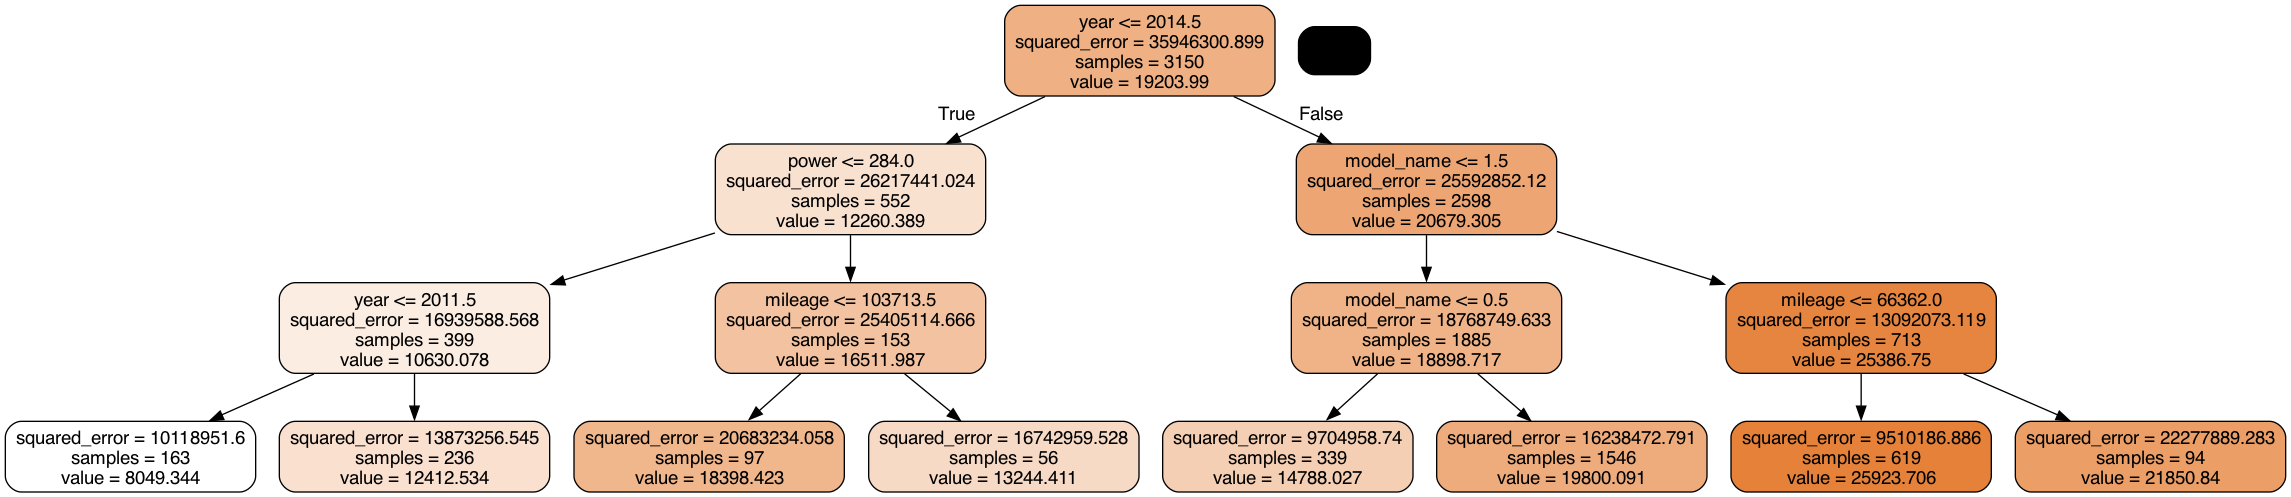

In [78]:
#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as tm
#Visualizing the regression tree
dot_data = StringIO()
export_graphviz(base, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names =['model_name', 'mileage', 'power', 'year', 'wheel_system_cat', 'engine_cylinders_V6_Flex_Fuel_Vehicle', 'fleet', 'savings_amount'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('car_price_tree.png')
Image(graph.create_png())

#### Coarse Grid Tuning

In [79]:
model = DecisionTreeRegressor(random_state=4) 
model.fit(X, y)
print("Maximum tree depth =", model.get_depth())
print("Maximum leaves =", model.get_n_leaves())

Maximum tree depth = 32
Maximum leaves = 4485


In [80]:
#Finding cross-validation error for trees 
parameters = {'max_depth':range(2,35, 3),'max_leaf_nodes':range(2,5000, 100)}
cv = KFold(n_splits = 5,shuffle=True,random_state=4)
model = GridSearchCV(DecisionTreeRegressor(random_state=4), parameters, n_jobs=-1,verbose=1,cv=cv,
                    scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
model.fit(X, y)
print (model.best_score_, model.best_params_) 

Fitting 5 folds for each of 550 candidates, totalling 2750 fits
-7826521.035438128 {'max_depth': 17, 'max_leaf_nodes': 202}


From the above cross-validation, the optimal hyperparameter values are max_depth = 17 and max_leaf_nodes = 202.

In [81]:
#Detailed results of k-fold cross validation
cv_results = pd.DataFrame(model.cv_results_)
#cv_results.head()

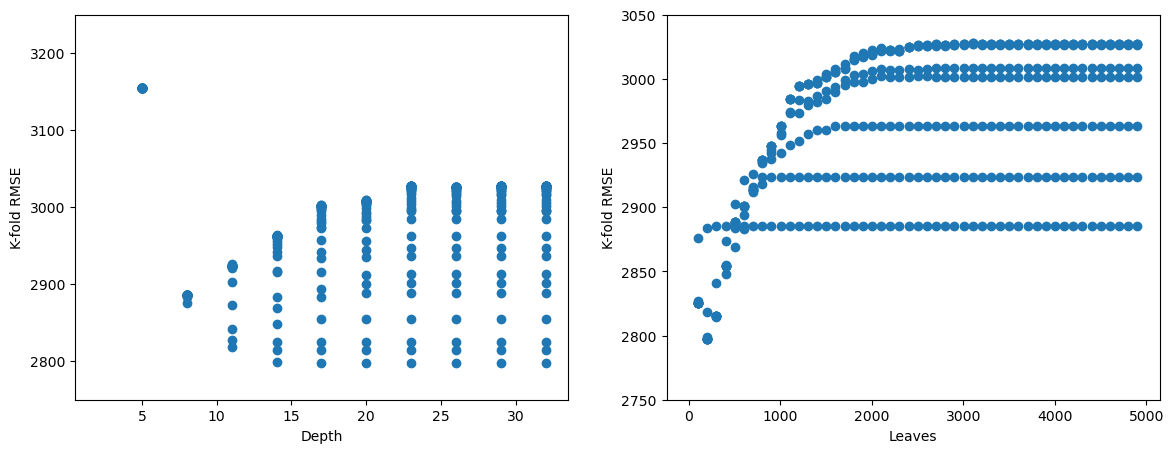

In [90]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, np.sqrt(-cv_results.mean_test_neg_mean_squared_error), 'o')
axes[0].set_ylim([2750, 3250])
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold RMSE')
axes[1].plot(cv_results.param_max_leaf_nodes, np.sqrt(-cv_results.mean_test_neg_mean_squared_error), 'o')
axes[1].set_ylim([2750, 3050])
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('K-fold RMSE');

We observe that for a depth of around 10 to 15, and number of leaves within 1500, we get the lowest 
K-fold RMSE. So, we do a finer search in that region to obtain more precise hyperparameter values.

In [91]:
#Developing the tree based on optimal hyperparameters found by Course Grid 
model = DecisionTreeRegressor(random_state=4, max_depth=17,max_leaf_nodes=202) 
model.fit(X, y)

DecisionTreeRegressor(max_depth=17, max_leaf_nodes=202, random_state=4)

In [92]:
#RMSE on test data for Course Grid
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

2015.4309168589184

#### Fine Grid Search

In [93]:
#Finding cross-validation error for trees
start_time = tm.time()
parameters = {'max_depth':range(10,15),'max_leaf_nodes':range(2,1500)}
cv = KFold(n_splits = 5,shuffle=True,random_state=4)
model = GridSearchCV(DecisionTreeRegressor(random_state=4), parameters, n_jobs=-1,verbose=1,cv=cv)
model.fit(X, y)
print (model.best_score_, model.best_params_) 
print("Time taken =", round((tm.time() - start_time)/60), "minutes")

Fitting 5 folds for each of 7490 candidates, totalling 37450 fits
0.7816670264731497 {'max_depth': 14, 'max_leaf_nodes': 207}
Time taken = 5 minutes


From the above cross-validation, the optimal hyperparameter values are max_depth = 12 and max_leaf_nodes = 263.

In [94]:
#Developing the tree based on optimal hyperparameters found by cross-validation
model = DecisionTreeRegressor(random_state=4, max_depth=12,max_leaf_nodes=263) 
model.fit(X, y)

DecisionTreeRegressor(max_depth=12, max_leaf_nodes=263, random_state=4)

In [95]:
#RMSE on test data
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

1824.6096520115836

In [96]:
#Print feature importances
importance = model.feature_importances_
sorted_importance = sorted(zip(X.columns, importance), key=lambda x: x[1], reverse=True)
for feature, importance_score in sorted_importance:
    print(f"{feature}: {importance_score}")

trimId: 0.4106058077165199
model_name: 0.23444143002892884
power: 0.13848818585798275
mileage: 0.08193331733884035
torque: 0.024829492305002268
length: 0.02348296132575457
engine_cylinders_V6: 0.01364058010858318
savings_amount: 0.010188703920559879
wheel_system_display_cat: 0.00830123759146622
wheelbase: 0.00790673698560935
height: 0.007099763435779587
year: 0.006398618064553708
highway_fuel_economy: 0.006128244396103102
fuel_tank_volume: 0.00551453502451502
width: 0.005475139554352632
wheel_system_cat: 0.005376541192469155
engine_displacement: 0.0029274039542386333
city_fuel_economy: 0.0020549496911309918
engine_cylinders_I4: 0.0017771013491055395
body_type_Sedan: 0.0013097177985532003
transmission_display_8_Speed_Automatic: 0.0010917416613759592
owner_count: 0.0007635401896188456
franchise_make: 0.0002642505089562544


Similar to the other models, timID and model_name are the most important predictors.

#### Cost-Complexity Pruning

In [97]:
CCPmodel = DecisionTreeRegressor(random_state = 4)#model without any restrictions
path= CCPmodel.cost_complexity_pruning_path(X,y)# Compute pruning path

In [98]:
alphas=path['ccp_alphas']
len(alphas)

4113

In [99]:
start_time = tm.time()
cv = KFold(n_splits = 5,shuffle=True,random_state=1)
tree = GridSearchCV(DecisionTreeRegressor(random_state=4), param_grid = {'ccp_alpha':alphas}, 
                     scoring = 'neg_mean_squared_error',n_jobs=-1,verbose=1,cv=cv)
tree.fit(X, y)
print (tree.best_score_, tree.best_params_)
print("Time taken =",round((tm.time()-start_time)/60), "minutes")

Fitting 5 folds for each of 4113 candidates, totalling 20565 fits
-7523215.660874766 {'ccp_alpha': 16584.831558986974}
Time taken = 5 minutes


In [100]:
model = DecisionTreeRegressor(ccp_alpha=16584.831558986974,random_state=4)
model.fit(X, y)
pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

2263.3041421882717

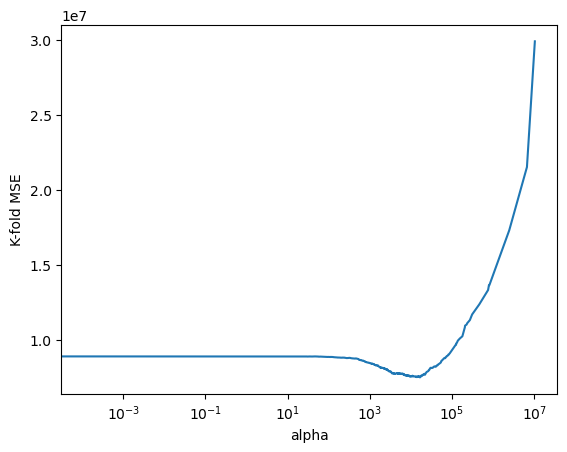

In [101]:
gridcv_results = pd.DataFrame(tree.cv_results_)
cv_error = -gridcv_results['mean_test_score']
#Visualizing the 5-fold cross validation error vs alpha
plt.plot(alphas,cv_error)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('K-fold MSE');

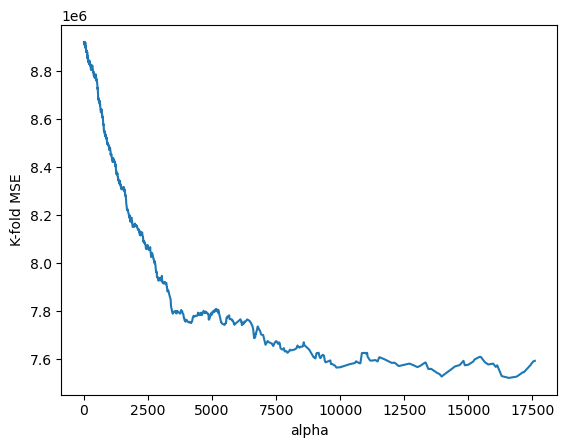

In [103]:
#Zooming in to see the alpha where the 5-fold cross validation error is minimizing
plt.plot(alphas[0:4000],cv_error[0:4000])
plt.xlabel('alpha')
plt.ylabel('K-fold MSE');

In [104]:
stime = tm.time()
trees=[]
for i in alphas:
    tree = DecisionTreeRegressor(ccp_alpha=i,random_state=4)
    tree.fit(X, y)
    trees.append(tree)
print(tm.time()-stime)

353.64823818206787


Text(0.5, 1.0, 'Depth vs alpha')

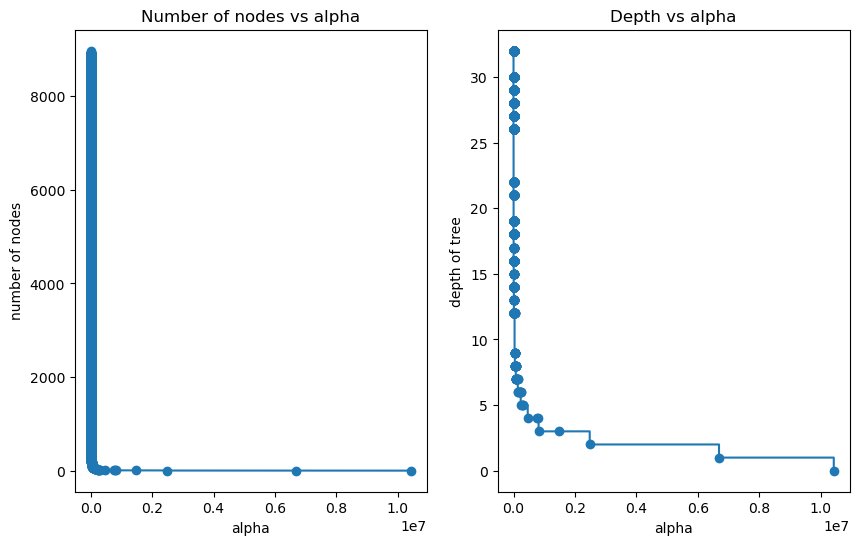

In [105]:
node_counts = [clf.tree_.node_count for clf in trees]
depth = [clf.tree_.max_depth for clf in trees]

fig, ax = plt.subplots(1, 2,figsize=(10,6))
ax[0].plot(alphas[0:5000], node_counts[0:5000], marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(alphas[0:5500], depth[0:5500], marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")

In [110]:
train_scores = [clf.score(X, y) for clf in trees]
test_scores = [clf.score(X_test, y_test) for clf in trees]

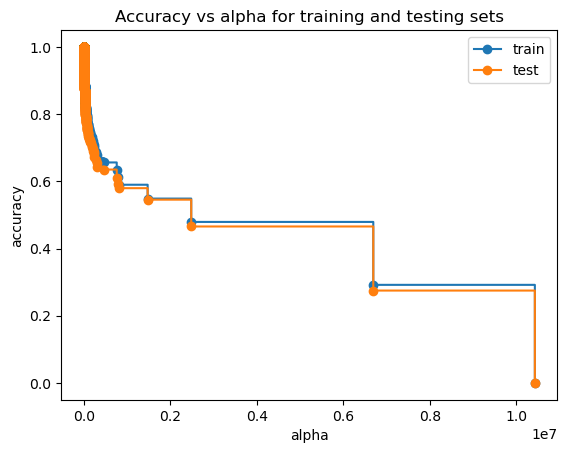

In [107]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(alphas[0:5450], train_scores[0:5450], marker="o", label="train", drawstyle="steps-post")#Plotting the zoomed-in plot (ignoring very high alphas), otherwise it is hard to see the trend
ax.plot(alphas[0:5450], test_scores[0:5450], marker="o", label="test", drawstyle="steps-post")#Plotting the zoomed-in plot (ignoring very high alphas), otherwise it is hard to see the trend
ax.legend()
plt.show()

#### Bagging 

In [111]:
#Bagging the results of 1 decision tree (just to see impact in RMSE)
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=1, random_state=4,n_jobs=-1).fit(X, y)

In [112]:
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

2047.0473567756935

In [113]:
#Bagging the results of 10 decision trees
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=4,n_jobs=-1).fit(X, y)

In [114]:
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

1001.1166820326778

In [115]:
#Bagging the results of 100 decision trees
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, random_state=4,n_jobs=-1).fit(X, y)

In [116]:
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

807.5798399160442

In [117]:
#Finding model accuracy vs number of trees
oob_rsquared={};test_rsquared={};oob_rmse={};test_rmse = {}
for i in np.linspace(10,400,40,dtype=int):
    model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=i, random_state=4,
                        n_jobs=-1,oob_score=True).fit(X, y)
    oob_rsquared[i]=model.oob_score_  #Returns the out-of_bag R-squared 
    test_rsquared[i]=model.score(X_test,y_test) #Returns the test R-squared 
    oob_rmse[i]=np.sqrt(mean_squared_error(model.oob_prediction_,y))
    test_rmse[i]=np.sqrt(mean_squared_error(model.predict(X_test),y_test))

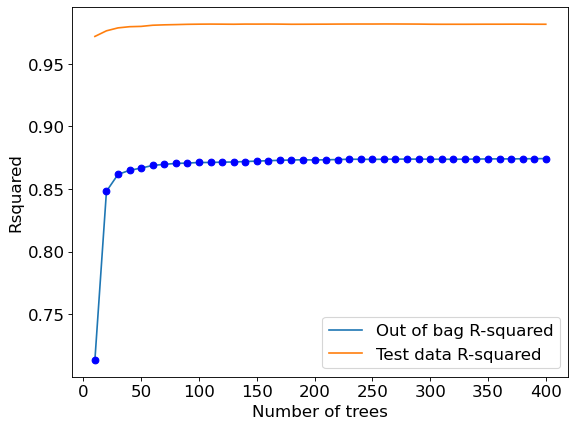

In [118]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),label = 'Out of bag R-squared')
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),'o',color = 'blue')
plt.plot(test_rsquared.keys(),test_rsquared.values(), label = 'Test data R-squared')
plt.xlabel('Number of trees')
plt.ylabel('Rsquared')
plt.legend()

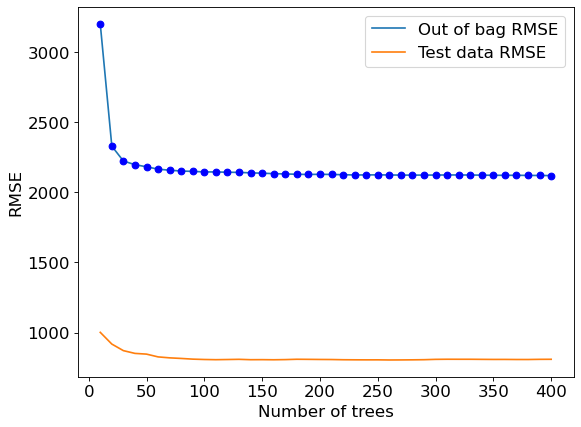

In [119]:
#Visualizing out-of-bag RMSE and test data RMSE
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
plt.plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
plt.plot(test_rmse.keys(),test_rmse.values(), label = 'Test data RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

The out-of-bag R-squared initially increases, and then stabilizes after a certain number of trees (around 50 in this case). Similarly, the RMSE follows the same trend. 

In [120]:
#Bagging with 50 trees
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50, random_state=4,
                        oob_score=True,n_jobs=-1).fit(X, y)

In [121]:
model.oob_score_

0.8667866707385805

In [122]:
#RMSE on test data
pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

845.8679476705987

In [123]:
#Optimizing bagging hyperparameters using grid search
n_samples = X_train.shape[0]
n_features = 20

params = {'base_estimator': [DecisionTreeRegressor(random_state = 4),LinearRegression()],
          'n_estimators': [50],
          'max_samples': [0.5,1.0],
          'max_features': [0.5,1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=4, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid.fit(X, y)

print('Train R^2 Score : %.3f'%bagging_regressor_grid.best_estimator_.score(X, y))
print('Test R^2 Score : %.3f'%bagging_regressor_grid.best_estimator_.score(X_test, y_test))
print('Best R^2 Score Through Grid Search : %.3f'%bagging_regressor_grid.best_score_)
print('Best Parameters : ',bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Train R^2 Score : 0.999
Test R^2 Score : 0.999
Best R^2 Score Through Grid Search : 0.876
Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=4), 'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}


In [126]:
#Model with optimal hyperparameters 
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50, random_state=4,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=1.0,max_samples=1.0).fit(X, y)

In [127]:
#RMSE on test data
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

893.4571947679904

Bagging showed to be the best way to reduce RMSE, producing a lower RMSE than all the other decision tree models. 

### Random forest 
*By Hiba Khatib*

**The first set of Random Forests will be performed on the MARS selected features.**

In [117]:
base_rf = RandomForestRegressor(random_state = 4).fit(X_train_mars, y_train_mars)
print("Base RandomForest Test RMSE: ", mean_squared_error(y_test_mars, base_rf.predict(X_test_mars), squared = False))
print("Base RandomForest Train RMSE: ", mean_squared_error(y_train_mars, base_rf.predict(X_train_mars), squared = False))
print("Base RandomForest R^2: ", r2_score(y_test_mars, base_rf.predict(X_test_mars)))

Base RandomForest Test RMSE:  3696.910020821465
Base RandomForest Train RMSE:  1445.662318831611
Base RandomForest R^2:  0.9018308866988485


In [141]:
base_rf_feats = pd.DataFrame(zip(base_rf.feature_names_in_, base_rf.feature_importances_)).reset_index()
base_rf_feats.sort_values(by = base_rf_feats.columns[2], ascending = False)

,index,0,1
8,8,model_name,0.623452
12,12,trimId,0.104791
7,7,mileage,0.096746
9,9,power,0.036915
11,11,torque,0.036540
10,10,savings_amount,0.015657
14,14,width,0.013138
4,4,height,0.011414
16,16,wheel_system_cat,0.009701
5,5,highway_fuel_economy,0.008553


#### Coarse grid search

In [132]:
rf_params = {'n_estimators': [250, 500, 700], 
            'max_depth': [4, 6, 8], 
            'max_leaf_nodes': range(2, 300, 75),
            'bootstrap': [True, False]}

rf_grid = GridSearchCV(RandomForestRegressor(random_state = 4), rf_params, n_jobs = -1, verbose = 1, 
                       scoring = 'neg_root_mean_squared_error')
rf_grid.fit(X_train_mars, y_train_mars)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=RandomForestRegressor(random_state=4), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [6, 8],
                         'max_leaf_nodes': [150, 200], 'n_estimators': [3000]},
             scoring='neg_mean_squared_error', verbose=1)

In [133]:
print("Best RandomForest parameters:", rf_grid.best_params_)
print("Best model train RMSE:", mean_squared_error(y_train_mars, rf_grid.predict(X_train_mars), squared = False))
print("Best model test RMSE:", mean_squared_error(y_test_mars, rf_grid.predict(X_test_mars), squared = False))
print("Best model R^2:", r2_score(y_test_mars, rf_grid.predict(X_test_mars)))

Best RandomForest parameters: {'bootstrap': True, 'max_depth': 8, 'max_leaf_nodes': 200, 'n_estimators': 3000}
Best model train RMSE: 3219.9047984351423
Best model test RMSE: 4146.782147344947
Best model R^2: 0.8764850440536625


In [140]:
rf_feats = pd.DataFrame(zip(rf_grid.best_estimator_.feature_names_in_, rf_grid.best_estimator_.feature_importances_)).reset_index()
rf_feats.sort_values(by = rf_feats.columns[2], ascending = False)

,index,0,1
8,8,model_name,0.661673
12,12,trimId,0.104228
7,7,mileage,0.088429
11,11,torque,0.038038
9,9,power,0.036892
14,14,width,0.010391
4,4,height,0.008332
16,16,wheel_system_cat,0.008292
15,15,year,0.008199
10,10,savings_amount,0.006378


In [ ]:
rf_results = pd.DataFrame(rf_grid.cv_results_)
rf_results.head(2)

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(rf_results.param_, (-cv_results.mean_test_score), 'o')
axes[0].set_xlabel('Learning rate')
axes[0].set_ylabel('MAE')
axes[1].plot(rf_results.param_n_estimators,(-cv_results.mean_test_score), 'o')
axes[1].set_xlabel('n estimators')
axes[1].set_ylabel('MAE');
axes[2].plot(base_estimator,(-cv_results.mean_test_score), 'o')
axes[2].set_xlabel('base estimator max_depth')
axes[2].set_ylabel('MAE');

#### Fine Grid Search

In [ ]:
rf_params2 = {'n_estimators': [250, 500, 700], 
            'max_depth': [4, 6, 8], 
            'max_leaf_nodes': range(2, 300, 75),
            'bootstrap': [True, False]}

rf_grid2 = GridSearchCV(RandomForestRegressor(random_state = 4), rf_params2, n_jobs = -1, verbose = 1, 
                       scoring = 'neg_root_mean_squared_error')
rf_grid2.fit(X_train_mars, y_train_mars)

In [ ]:
print("Best RandomForest parameters:", rf_grid2.best_params_)
print("Best model train RMSE:", mean_squared_error(y_train_mars, rf_grid2.predict(X_train_mars), squared = False))
print("Best model test RMSE:", mean_squared_error(y_test_mars, rf_grid2.predict(X_test_mars), squared = False))
print("Best model R^2:", r2_score(y_test_mars, rf_grid2.predict(X_test_mars)))
rf_feats2 = pd.DataFrame(zip(rf_grid2.best_estimator_.feature_names_in_, rf_grid2.best_estimator_.feature_importances_)).reset_index()
rf_feats2.sort_values(by = rf_feats2.columns[2], ascending = False)

**Now we will continue with analysis on our selected features**

The best RMSE and R^2 resulted from ___ params using the MARS model

### AdaBoost & Gradient boosting
*By YuYan Zhang*

### XGBoost
*By Emily Leibfritz*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.